In [2]:
# Import das Bibliotecas
from dotenv import load_dotenv
import psycopg
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

In [3]:
# Executa a função para carregar as variáveis do arquivo .env no ambiente
load_dotenv()

True

In [4]:
# Conexão com o banco de dados
def get_db_connection():
    """Cria e retorna uma conexão com o banco de dados."""
    try:
        conn = psycopg.connect(
            host="localhost",
            dbname=os.getenv("DB_NAME"),
            user=os.getenv("DB_USER"),
            password=os.getenv("DB_PASSWORD"),
            port=os.getenv("DB_PORT")
        )
        return conn
    except Exception as e:
        print(f"Erro ao conectar ao banco de dados: {e}")
        raise e

In [5]:
def converter_meses_para_portugues(df, coluna_mes):
    """
    Converte uma coluna de meses (números ou strings) para nomes em português.
    
    Args:
        df: DataFrame pandas.
        coluna_mes: Nome da coluna com os meses (números 1-12 ou strings).
    
    Returns:
        DataFrame com a coluna modificada e ordenada corretamente.
    """
    # Mapeamentos
    meses_de_numero = {
        1: 'Janeiro',
        2: 'Fevereiro',
        3: 'Março',
        4: 'Abril',
        5: 'Maio',
        6: 'Junho',
        7: 'Julho',
        8: 'Agosto',
        9: 'Setembro',
        10: 'Outubro',
        11: 'Novembro',
        12: 'Dezembro'
    }
    
    meses_de_ingles = {
        'January': 'Janeiro',
        'February': 'Fevereiro',
        'March': 'Março',
        'April': 'Abril',
        'May': 'Maio',
        'June': 'Junho',
        'July': 'Julho',
        'August': 'Agosto',
        'September': 'Setembro',
        'October': 'Outubro',
        'November': 'Novembro',
        'December': 'Dezembro'
    }
    
    # Verifica o tipo dos dados na coluna
    sample_value = df[coluna_mes].iloc[0] if len(df) > 0 else None
    
    if sample_value is not None:
        if isinstance(sample_value, (int, float)) and not pd.isna(sample_value):
            # Se for numérico
            df[coluna_mes] = df[coluna_mes].map(meses_de_numero)
        elif isinstance(sample_value, str):
            # Se for string, verifica se está em inglês
            if sample_value in meses_de_ingles:
                df[coluna_mes] = df[coluna_mes].map(meses_de_ingles)
            # Se já estiver em português, não faz nada
        else:
            raise ValueError("Formato de mês não reconhecido. Use números (1-12) ou nomes em inglês.")
    
    # Garante a ordem cronológica
    ordem_meses = list(meses_de_numero.values())
    df[coluna_mes] = pd.Categorical(
        df[coluna_mes],
        categories=ordem_meses,
        ordered=True
    )
    
    return df.sort_values(coluna_mes)

In [6]:
def execute_query(query, conn, cursor, return_df = True):
    conn.rollback() # Reinicia a transação (caso tenha alguma transação que tenha dado errado)

    cursor.execute(query)

    # Pegando os dados da consulta
    result = cursor.fetchall()

    # Pegando os nomes das colunas
    columns = cursor.description

    # Colocando o nome das colunas 
    df = [{columns[index][0]: column for index, column in enumerate(value)} for value in result]

    # Transformando de DataFrame para fazer o gráfico
    return pd.DataFrame(df)

In [7]:
# Estabelecendo a conexão
conn = get_db_connection()

# Estabelecendo o cursor para executar consultas
cursor = conn.cursor()

In [8]:
query = '''
        SELECT 
                ha.year_month AS ano_mes,
                ha.pollutant_code AS poluente,
                ha.state_code AS uf,
                ha.total_health_cases AS numero_total_casos,
                ha.monthly_avg_pollution AS media_poluicao
        FROM 
                gold.mart_health_vs_air_quality AS ha
        GROUP BY
                1, 2, 3, 4, 5
'''
df = execute_query(query, conn, cursor, True)

In [9]:
# Converter para datetime e extrair o mês
df['ano_mes'] = pd.to_datetime(df['ano_mes'])
df['mes'] = df['ano_mes'].dt.month_name()

In [10]:
df = converter_meses_para_portugues(df, coluna_mes='mes')

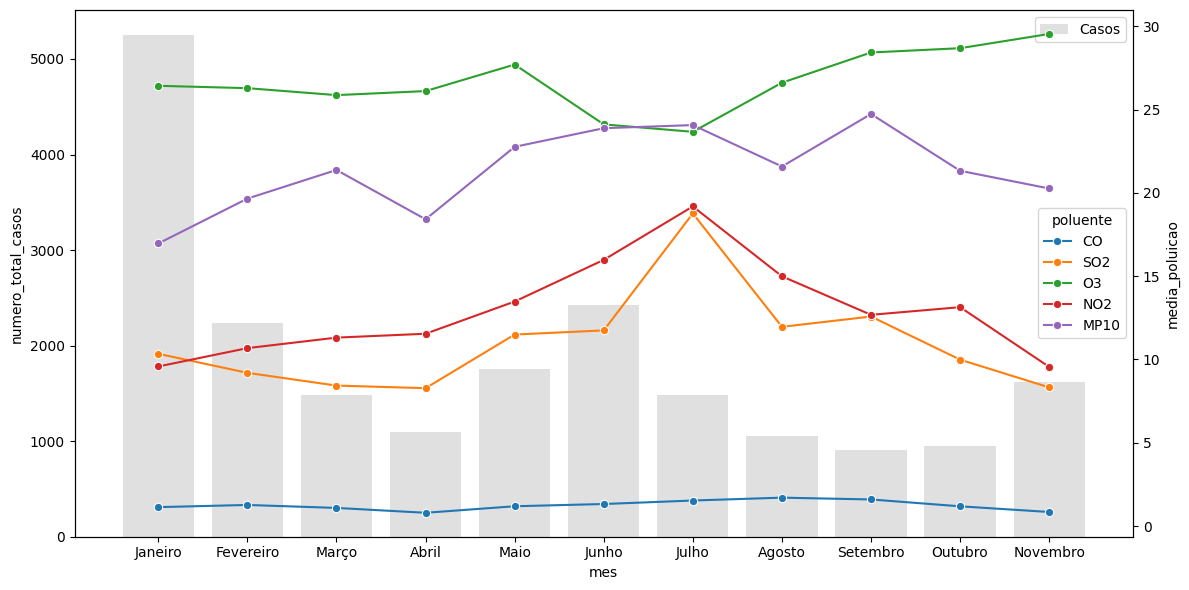

In [11]:
# Gráfico duplo: linha -> Sériel Temporal dos poluentes
#                barras -> número de casos
# Colocar filtros: estado e poluente para o gŕafico não ficar tão poluído
plt.figure(figsize=(12, 6))

sns.barplot(data=df, x='mes', y='numero_total_casos',color='lightgray', alpha=0.7, label='Casos', errorbar=None)
ax2 = plt.twinx()
sns.lineplot(data=df, x='mes', y='media_poluicao', hue='poluente', marker='o', errorbar=None)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Converter para numérico, forçando erros para NaN
df['media_poluicao'] = pd.to_numeric(df['media_poluicao'], errors='coerce')
df['numero_total_casos'] = pd.to_numeric(df['numero_total_casos'], errors='coerce')

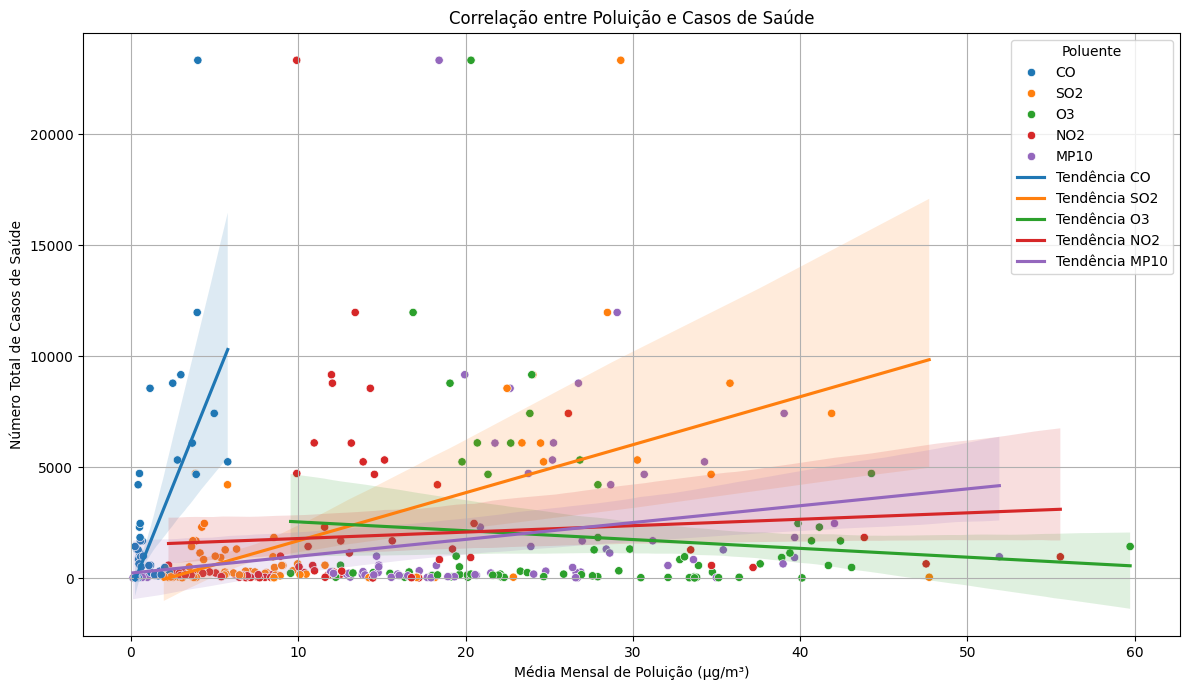

In [13]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='media_poluicao', y='numero_total_casos', hue='poluente')

# Adicionar linha de tendência manualmente (para cada poluente)
for poluente in df['poluente'].unique():
    subset = df[df['poluente'] == poluente]
    sns.regplot(data=subset, x='media_poluicao', y='numero_total_casos', 
               scatter=False, label=f'Tendência {poluente}')

plt.title('Correlação entre Poluição e Casos de Saúde')
plt.xlabel('Média Mensal de Poluição (µg/m³)')
plt.ylabel('Número Total de Casos de Saúde')
plt.legend(title='Poluente')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
fig = go.Figure()

for poluente in df['poluente'].unique():
    subset = df[df['poluente'] == poluente]
    
    # Adicionar pontos
    fig.add_trace(go.Scatter(
        x=subset['media_poluicao'],
        y=subset['numero_total_casos'],
        mode='markers',
        name=poluente,
        hovertext=subset.apply(lambda row: f"UF: {row['uf']}<br>Mês: {row['mes']}", axis=1)
    ))
    
    # Calcular regressão linear manualmente
    x = subset['media_poluicao'].values
    y = subset['numero_total_casos'].values
    coeffs = np.polyfit(x, y, 1)
    trendline = np.poly1d(coeffs)
    
    # Adicionar linha de tendência
    fig.add_trace(go.Scatter(
        x=x,
        y=trendline(x),
        mode='lines',
        name=f'Tendência {poluente}',
        line=dict(dash='dash')
    ))

fig.update_layout(
    title='Correlação entre Poluição e Casos de Saúde',
    xaxis_title='Média Mensal de Poluição (µg/m³)',
    yaxis_title='Número Total de Casos de Saúde',
    width=1000,
    height=600
)

fig.show()

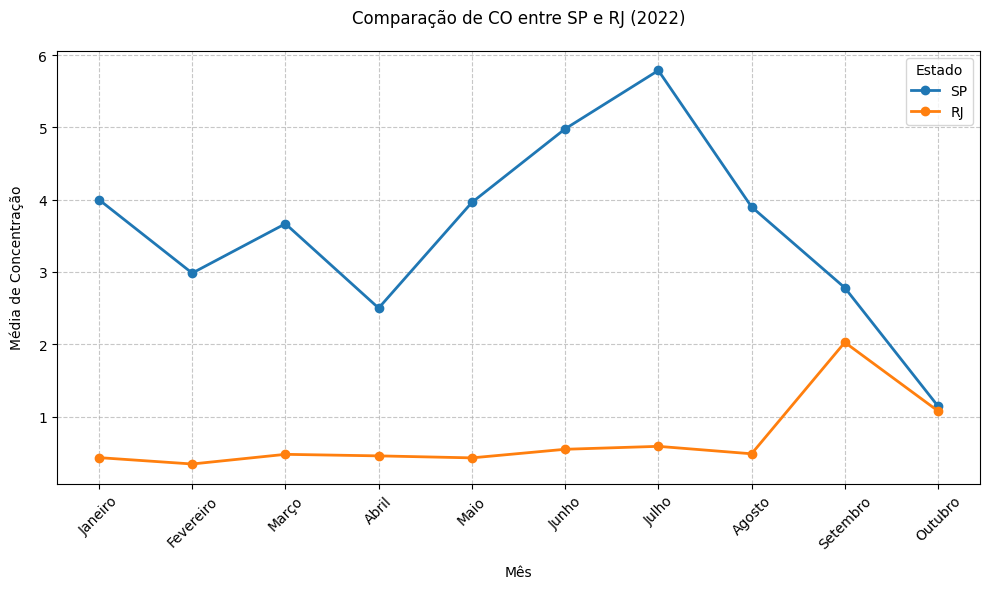

In [15]:
# Filtros para colocar no gráfico
pollutant = 'CO' 
state1 = 'SP'
state2 = 'RJ'

# Filtrar os dados (mantendo a ordem original)
filtered = df[(df['poluente'] == pollutant) & 
            (df['uf'].isin([state1, state2]))]

# Criar o gráfico mantendo a ordem dos dados
plt.figure(figsize=(10, 6))

for state in [state1, state2]:
    state_data = filtered[filtered['uf'] == state]
    # Usar range(len()) para manter a ordem original dos meses
    plt.plot(range(len(state_data)), state_data['media_poluicao'], 
             marker='o', label=state, linewidth=2)

# Configurar os ticks do eixo x com os meses na ordem original
plt.xticks(range(len(state_data)), state_data['mes'], rotation=45)

plt.title(f'Comparação de {pollutant} entre {state1} e {state2} (2022)', pad=20)
plt.xlabel('Mês', labelpad=10)
plt.ylabel('Média de Concentração', labelpad=10)
plt.legend(title='Estado')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

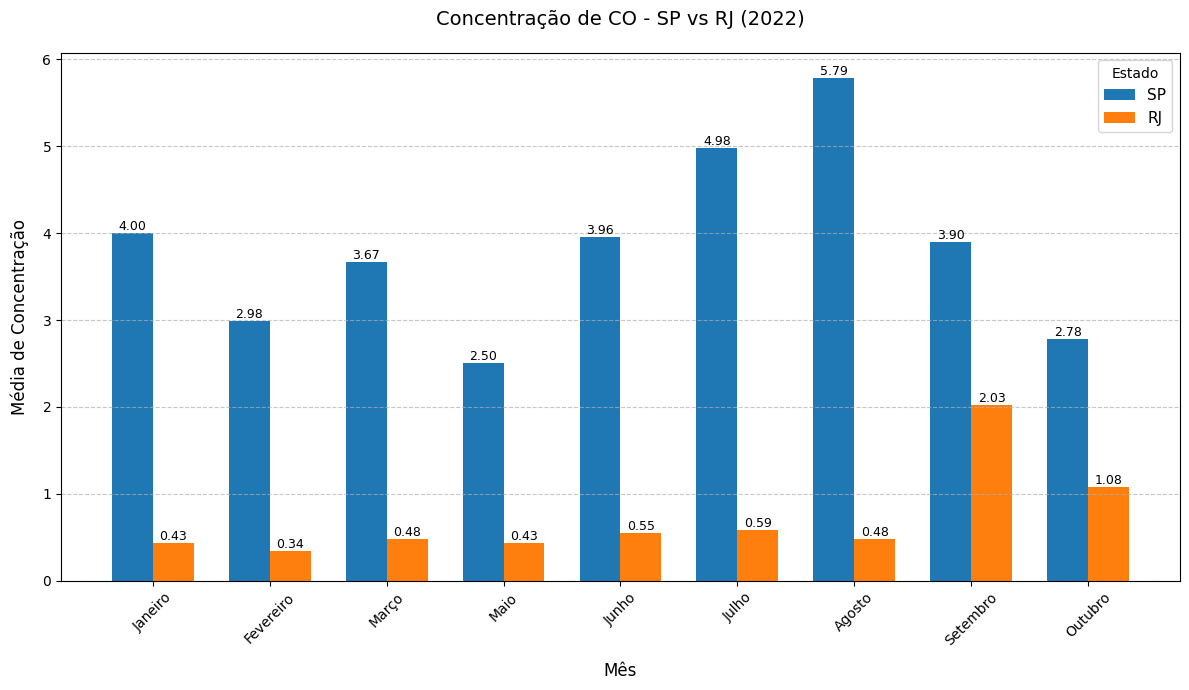

In [16]:
# Filtros
pollutant = 'CO'
state1 = 'SP'
state2 = 'RJ'

# Filtrar os dados
filtered = df[(df['poluente'] == pollutant) & 
             (df['uf'].isin([state1, state2]))]

# Encontrar meses comuns a ambos estados
common_months = set(filtered[filtered['uf'] == state1]['mes']).intersection(
                set(filtered[filtered['uf'] == state2]['mes']))
common_months = sorted(common_months, key=lambda x: ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto',
                                                     'Setembro', 'Outubro', 'Novembro', 'Dezembro'].index(x))

# Filtrar apenas meses comuns
state1_data = filtered[(filtered['uf'] == state1) & (filtered['mes'].isin(common_months))].sort_values('mes')
state2_data = filtered[(filtered['uf'] == state2) & (filtered['mes'].isin(common_months))].sort_values('mes')

# Verificar se temos dados para plotar
if len(common_months) == 0:
    print(f"Não há meses com dados para ambos {state1} e {state2}")
else:
    # Configurações do gráfico
    bar_width = 0.35
    x_indices = np.arange(len(common_months))
    
    plt.figure(figsize=(12, 7))
    
    # Criar barras
    bars1 = plt.bar(x_indices - bar_width/2, state1_data['media_poluicao'], 
                    width=bar_width, label=state1, color='#1f77b4')
    bars2 = plt.bar(x_indices + bar_width/2, state2_data['media_poluicao'], 
                    width=bar_width, label=state2, color='#ff7f0e')
    
    # Adicionar valores nas barras
    def add_values(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=9)
    
    add_values(bars1)
    add_values(bars2)
    
    # Personalização
    plt.title(f'Concentração de {pollutant} - {state1} vs {state2} (2022)', pad=20, fontsize=14)
    plt.xlabel('Mês', labelpad=10, fontsize=12)
    plt.ylabel('Média de Concentração', labelpad=10, fontsize=12)
    plt.xticks(x_indices, common_months, rotation=45)
    plt.legend(title='Estado', fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()

* Gráfico de dois eixos 
    - Eixo Y 1: Número de casos de uma SRAG
    - EIXO Y 2: Concetração de um Poluente específico
    - EIXO X: Meses

`fact_health_cases`:
    - `case_classification_id`
    - `case_count`
    - `first_symptoms_date_id`
    - `patient_id`
    - `location_id`
`dim_date`:
    - `month_name`
`dim_case_classification_id`:
    - `final_classification`
`dim_locations`:
    - `state_code`


In [17]:
query = '''
        SELECT 
        dcc.final_classification AS classificacao_final,
        dl.state_code AS uf,
        dd.month_name AS mes,
        SUM(fhc.case_count) AS numero_total_casos,
        COUNT(DISTINCT fhc.patient_id) AS numero_afetados
    FROM 
        gold.fact_health_cases fhc
    JOIN 
        gold.dim_case_classifications dcc ON fhc.case_classification_id = dcc.case_classification_id
    JOIN 
        gold.dim_locations dl ON fhc.location_id = dl.location_id
    JOIN 
        gold.dim_date dd ON fhc.first_symptoms_date_id = dd.date_id
    WHERE
        final_classification != 'IGNORADO'
    GROUP BY 
        dcc.final_classification,
        dl.state_code,
        dd.month_name
    ORDER BY 
        numero_total_casos DESC;
'''

df = execute_query(query, conn, cursor, True)

In [18]:
df_casos = converter_meses_para_portugues(df, coluna_mes='mes')

In [19]:
query = '''
        SELECT 
            year_month AS ano_mes,
            state_code AS uf,
            pollutant_code AS poluente,
            monthly_avg_pollution AS media_poluicao
        FROM
            gold.mart_health_vs_air_quality
        GROUP BY
            1, 2, 3, 4

'''

df_poluicao = execute_query(query, conn, cursor, True)

In [20]:
df_poluicao['ano_mes'] = pd.to_datetime(df_poluicao['ano_mes'])
df_poluicao['mes'] = df_poluicao['ano_mes'].dt.month_name()
df_poluicao = converter_meses_para_portugues(df_poluicao, coluna_mes='mes')

In [21]:
df_casos

,classificacao_final,uf,mes,numero_total_casos,numero_afetados
0,SRAG POR COVID-19,SP,Janeiro,16817,2432
260,SRAG POR INFLUENZA,MS,Janeiro,15,14
55,SRAG NAO ESPECIFICADO,RJ,Janeiro,655,370
221,SRAG POR INFLUENZA,RJ,Janeiro,28,26
355,SRAG POR OUTRO AGENTE ETIOLOGICO,PR,Janeiro,2,2
...,...,...,...,...,...
270,SRAG POR OUTRO VIRUS RESPIRATORIO,RS,Dezembro,13,7
91,SRAG NAO ESPECIFICADO,PR,Dezembro,308,213
385,SRAG POR OUTRO VIRUS RESPIRATORIO,MS,Dezembro,1,1
308,SRAG NAO ESPECIFICADO,BA,Dezembro,6,6


In [22]:
df_poluicao

,ano_mes,uf,poluente,media_poluicao,mes
0,2022-01-01,BA,CO,0.36635808748728382503,Janeiro
31,2022-01-01,SP,SO2,29.2782152230971129,Janeiro
30,2022-01-01,SP,O3,20.3265067616450554,Janeiro
29,2022-01-01,SP,NO2,9.9077490774907749,Janeiro
28,2022-01-01,SP,MP10,18.4211143166245943,Janeiro
...,...,...,...,...,...
333,2022-11-01,MG,NO2,10.5890502793296089,Novembro
334,2022-11-01,MG,O3,59.7228770949720670,Novembro
335,2022-11-01,MG,SO2,3.6248882681564246,Novembro
337,2022-11-01,MS,MP10,26.5803571428571429,Novembro


In [23]:
estado_selecionado = 'SP'  # Exemplo: São Paulo
poluente_selecionado = 'CO'  # Exemplo: Gas Carbônico
# COlocar filtro para selecionar a srag específica

# Filtrar os dados
df_poluente_filtrado = df_poluicao[(df_poluicao['poluente'] == poluente_selecionado) & 
                                 (df_poluicao['uf'] == estado_selecionado)]
df_casos_filtrado = df_casos[df_casos['uf'] == estado_selecionado]

/tmp/ipykernel_11109/2522100043.py:5: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:lightgray'` for the same effect.




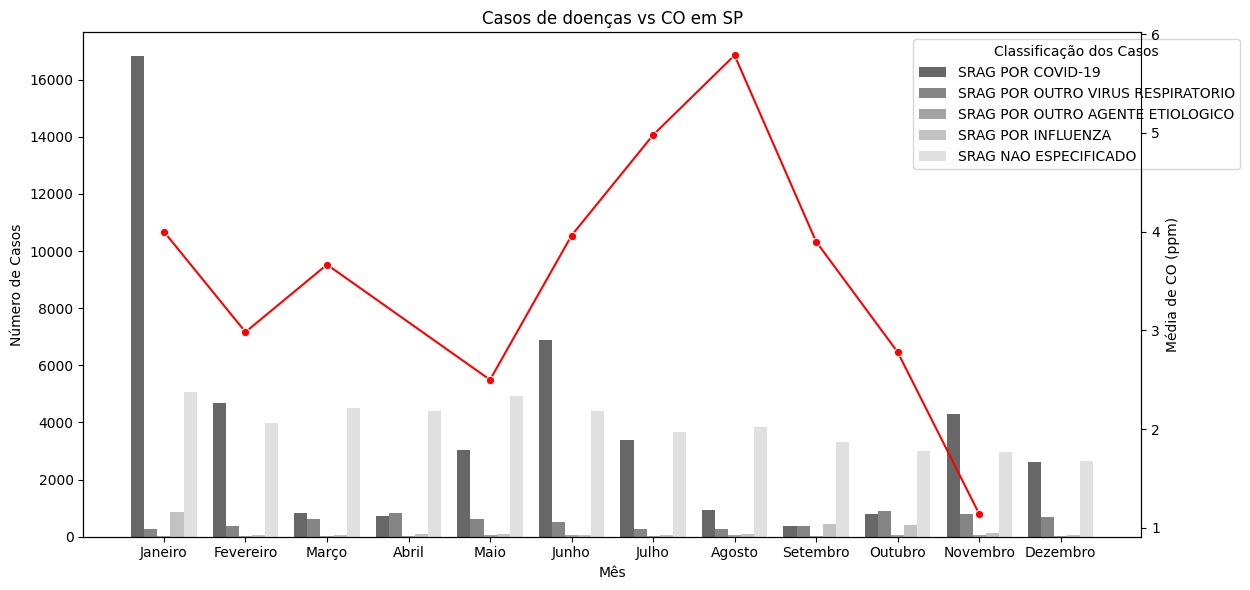

In [24]:
# Criar a figura
plt.figure(figsize=(12, 6))

# Gráfico de barras (casos)
ax1 = sns.barplot(data=df_casos_filtrado, 
                 x='mes', 
                 y='numero_total_casos',
                 color='lightgray',
                 hue='classificacao_final',
                 alpha=0.7, 
                 errorbar=None)

# Gráfico de linhas (poluição) no eixo secundário
ax2 = plt.twinx()
sns.lineplot(data=df_poluente_filtrado, 
            x='mes', 
            y='media_poluicao', 
            color='red',  # Você pode escolher uma cor diferente
            marker='o', 
            errorbar=None,
            ax=ax2)

# Configurações do gráfico
plt.title(f'Casos de doenças vs {poluente_selecionado} em {estado_selecionado}')
ax1.set_xlabel('Mês')
ax1.set_ylabel('Número de Casos')
ax2.set_ylabel(f'Média de {poluente_selecionado} (ppm)')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar legenda
ax1.legend(title='Classificação dos Casos', bbox_to_anchor=(1.1, 1))
plt.show()

In [25]:
# Obter lista de estados e poluentes únicos
estados = df_casos['uf'].unique()
poluentes = df_poluicao['poluente'].unique()

@interact(
    estado=Dropdown(options=estados, value=estados[0], description='Estado:'),
    poluente=Dropdown(options=poluentes, value=poluentes[0], description='Poluente:')
)
def plotar_grafico(estado, poluente):
    # Filtrar os dados
    df_poluente_filtrado = df_poluicao[(df_poluicao['poluente'] == poluente) & 
                                     (df_poluicao['uf'] == estado)]
    df_casos_filtrado = df_casos[df_casos['uf'] == estado]

    # Criar a figura
    plt.figure(figsize=(12, 6))

    # Gráfico de barras (casos)
    ax1 = sns.barplot(data=df_casos_filtrado, 
                     x='mes', 
                     y='numero_total_casos',
                     color='lightgray',
                     hue='classificacao_final',
                     alpha=0.7, 
                     errorbar=None)

    # Gráfico de linhas (poluição) no eixo secundário
    ax2 = plt.twinx()
    sns.lineplot(data=df_poluente_filtrado, 
                x='mes', 
                y='media_poluicao', 
                color='red',
                marker='o', 
                errorbar=None,
                ax=ax2)

    # Configurações do gráfico
    plt.title(f'Casos de doenças vs {poluente} em {estado}')
    ax1.set_xlabel('Mês')
    ax1.set_ylabel('Número de Casos')
    ax2.set_ylabel(f'Média de {poluente} (µg/m³)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    ax1.legend(title='Classificação dos Casos', bbox_to_anchor=(1.1, 1))
    plt.show()

interactive(children=(Dropdown(description='Estado:', options=('SP', 'MS', 'RJ', 'PR', 'RS', 'ES', 'BA', 'MG')…